In [1]:
import numpy as np
from skimage.measure import regionprops_table
import pandas as pd
import tifffile
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

In [8]:
sns.set_context("paper")
# plt.style.use(r"D:\FeedbackControl\figures\style\stylesheet.rc")
savepath = Path(r"Figure 4")

mpl.rc("axes", facecolor="#ffffff00", grid=False, edgecolor="k", labelcolor="k")
mpl.rc("figure", facecolor="#00000000", dpi=100)
mpl.rc("axes.spines", top=False, right=False, )
mpl.rc("xtick", color="k", bottom=True)
mpl.rc("ytick", color="k", left=True)
mpl.rc("legend", fontsize="small")

(228, 3, 1600, 1600)
(228, 3, 800, 800)
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227]


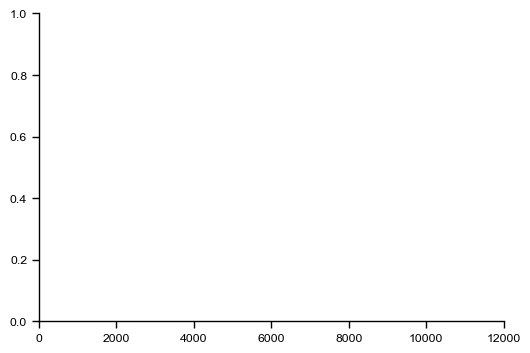

In [9]:
base_dir = Path(r"D:\FeedbackControl\data\RTx3 imaging\tagrfp")

# arr = tifffile.imread(base_dir / "cycle10.1_patterns.tif")

stem = "cycle10.1"
initial = stem + "_patterns.tif"
decay = stem + "_decay_patterns.tif"
fbc = stem + "_fbc_patterns.tif"

arr1 = tifffile.imread(base_dir / initial)[:80]
arr2 = tifffile.imread(base_dir / decay)[7:]
arr3 = tifffile.imread(base_dir / fbc)

arr = np.vstack((arr1, arr2, arr3))

print(arr.shape)

arr = arr[:, :, 400:1200, 400:1200]

print(arr.shape)

masks = arr[:, 1]
vals = arr[:, 0]

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
plt.xlim(0, 12000)

df = {
    "intensity": [],
    "frame": []
}

for frame in range(len(masks)):
    props = regionprops_table(masks[frame], vals[frame], properties=["intensity_mean"])

    df["intensity"].extend(props["intensity_mean"])
    df["frame"].extend([frame for _ in props["intensity_mean"]])

    # sns.histplot(intensities, label=frame)
    # plt.show()


df = pd.DataFrame(df)
print(df["frame"].unique())
df["Time (mins)"] = df["frame"] / 2



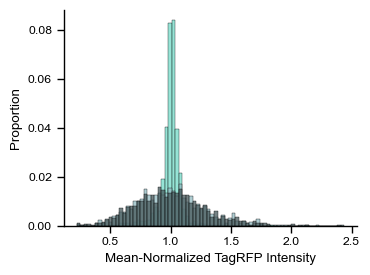

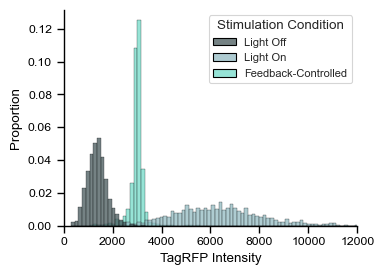

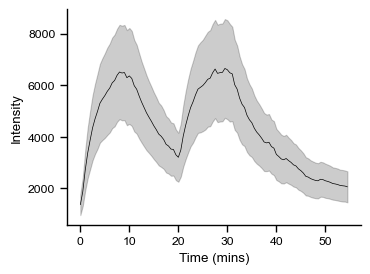

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
plt.tight_layout(rect = [0.05, 0.05, 0.95, 0.95])
df["mean_normalized_intensity"] = df["intensity"] / df["frame"].map(df.groupby("frame")["intensity"].mean())
df["Time2 (mins)"] = df["Time (mins)"] // 2 * 2

sns.histplot(df[df["frame"].isin([0, 20, 227])], x="mean_normalized_intensity", legend=False,
             hue="Time (mins)",ax=ax, palette=["#47595C", "#93BBC2", "#74DBC9"], edgecolor="k", alpha=0.75, stat="proportion")

# legend = ax.get_legend()
# handles = legend.legend_handles
# ax.legend(handles, ["Light Off", "Light On", "Feedback-Controlled"], title="Stimulation Condition")


plt.xlabel("Mean-Normalized TagRFP Intensity")
plt.savefig(savepath / "mean-normed-intensity.pdf")
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(4, 3))
plt.tight_layout(rect = [0.05, 0.05, 0.95, 0.95])

sns.histplot(df[df["frame"].isin([0, 20, 227])], x="intensity", binwidth=150,
             hue="Time (mins)",ax=ax, palette=["#47595C", "#93BBC2", "#74DBC9"], edgecolor="k", alpha=0.75, stat="proportion")

legend = ax.get_legend()
handles = legend.legend_handles
ax.legend(handles, ["Light Off", "Light On", "Feedback-Controlled"], title="Stimulation Condition")


plt.xlabel("TagRFP Intensity")
plt.xlim([0, 12000])
plt.savefig(savepath / "intensity.pdf")
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(4, 3))
plt.tight_layout(rect = [0.05, 0.05, 0.95, 0.95])

sns.lineplot(df[df["Time (mins)"] < 55], x="Time (mins)", y="intensity", errorbar=("sd", 1), err_style="band", color="k", linewidth=0.5, markers="o")
plt.xlabel("Time (mins)")
plt.ylabel("Intensity")
plt.savefig(savepath / "intensity_timecourse.pdf")
plt.show()

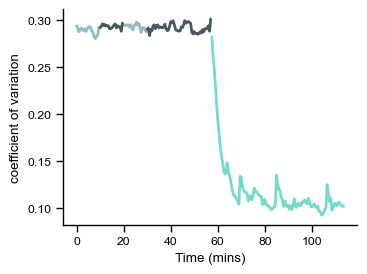

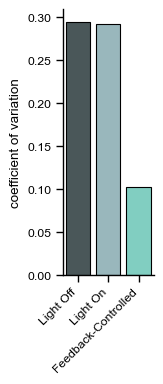

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
plt.tight_layout(rect = [0.05, 0.05, 0.95, 0.95])

t = df.groupby("Time (mins)")
mean = t["intensity"].mean()
std = t["intensity"].std()

l = 2.0

sns.lineplot((std / mean).iloc[:20], color="#93BBC2", alpha=1.0, linewidth=l)
sns.lineplot((std / mean).iloc[40:60], color="#93BBC2", alpha=1.0, linewidth=l)
sns.lineplot((std / mean).iloc[20:40], color="#47595C", alpha=1.0, linewidth=l)
sns.lineplot((std / mean).iloc[60:115], color="#47595C", alpha=1.0, linewidth=l)
sns.lineplot((std / mean).iloc[115:], color="#74DBC9", alpha=1.0, linewidth=l)

plt.ylabel("coefficient of variation")
plt.xlabel("Time (mins)")

plt.savefig(savepath / "cov_over_time.pdf")
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(2, 4))
plt.tight_layout(rect = [0.10, 0.1, 0.90, 0.9])

the_frames = [0, 20, 227]

frames = df[df["frame"].isin(the_frames)].copy()
frames["label"] = frames["frame"].map({f: key for f, key in zip(the_frames, ["Light Off", "Light On", "Feedback-Controlled"])})
t = frames.groupby("label")
mean = t["intensity"].mean()
std = t["intensity"].std()

names = ["Light Off", "Light On", "Feedback-Controlled"]

sns.barplot(x=names, y=(std/mean).loc[names], hue=names, order=names, palette=["#47595C", "#93BBC2", "#74DBC9"], edgecolor="k")
plt.xticks(rotation=45, ha='right')
plt.ylabel("coefficient of variation")
plt.savefig(savepath / "cov_by_condition.pdf")
plt.show()

In [12]:
from laptrack import LapTrack
from tqdm import tqdm


def process_masks(masks, intensities):
    collect_spots = []

    for t, frame in tqdm(enumerate(masks)):
        props = regionprops_table(frame, intensity_image=np.moveaxis(intensities[t], 0, -1),
                                  properties=['label', 'area', 'centroid', "intensity_mean"])

        df = pd.DataFrame(props)
        df["frame"] = t
        df = df.rename(columns={"centroid-0": "px_y", "centroid-1": "px_x"})

        # print(df)

        collect_spots.append(df)

    spots_df = pd.concat([s for s in collect_spots], ignore_index=True)

    return spots_df


def track_spots(spots_df):
    max_distance = 20

    lt = LapTrack(
        metric="sqeuclidean",
        # The similarity metric for particles. See `scipy.spatial.distance.cdist` for allowed values.
        splitting_metric="sqeuclidean",
        merging_metric="sqeuclidean",
        gap_closing_metric="sqeuclidean",
        # the square of the cutoff distance for the "sqeuclidean" metric
        cutoff=max_distance ** 2,
        splitting_cutoff=False,  # or False for non-splitting case
        merging_cutoff=False,  # or False for non-merging case
        gap_closing_cutoff=max_distance ** 2,
        gap_closing_max_frame_count=2,
    )

    track_df, split_df, merge_df = lt.predict_dataframe(
        spots_df,
        coordinate_cols=[
            "px_x",
            "px_y",
        ],  # the column names for the coordinates
        frame_col="frame",  # the column name for the frame (default "frame")
        only_coordinate_cols=False,
    )

    track_df = track_df.rename(columns={"frame_y": "frame"})

    return track_df


print(masks.shape, vals.shape)

tracks_path = base_dir / "tracked.csv"

if not tracks_path.exists():
    spots = process_masks(masks, arr)
    tracked_spots_df = track_spots(spots)
    tracked_spots_df.to_csv(tracks_path)

(228, 800, 800) (228, 800, 800)


R^2: 0.35810883350674394
Coef: [-0.00026424] Intercept: 1.2344243827455563


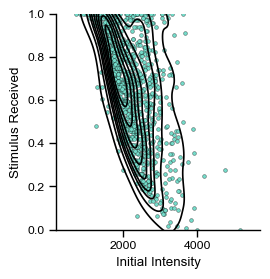

In [22]:
tracked_spots_df = pd.read_csv(tracks_path)
tracked_spots_df["intensity"] = tracked_spots_df["intensity_mean-0"]
tracked_spots_df["seg-label"] = tracked_spots_df["intensity_mean-1"]
tracked_spots_df["stim"] = tracked_spots_df["intensity_mean-2"] > 0
# tracked_spots_df["intensity_bin"] = tracked_spots_df["intensity"] // 125 * 125

tracked_spots_df["track_n_spots"] = tracked_spots_df["track_id"].map(tracked_spots_df.groupby("track_id")["frame"].count())

good_tracked_spots = tracked_spots_df[tracked_spots_df["track_n_spots"] > 200]
good_tracked_spots = good_tracked_spots[good_tracked_spots["frame"] > 115]
t = good_tracked_spots.groupby("track_id")

fig, ax = plt.subplots(1, 1, figsize=(3, 3))
plt.tight_layout(rect = [0.05, 0.05, 0.95, 0.95])

sns.kdeplot(x=t["intensity"].first(), y=t["stim"].mean(), color="k")
sns.scatterplot(x=t["intensity"].first(), y=t["stim"].mean(), color="#74DBC9", edgecolor="k", s=7.5)

from sklearn.linear_model import LinearRegression
model = LinearRegression()
X = t["intensity"].first().values.reshape(-1, 1)
y = t["stim"].mean().values
model.fit(X, y)
print("R^2:", model.score(X, y))
print("Coef:", model.coef_, "Intercept:", model.intercept_)

plt.xlabel("Initial Intensity")
plt.ylabel("Stimulus Received")
plt.ylim(0, 1.0)
plt.savefig(savepath / "stimulus_required.pdf")
plt.show()